# IMEC2001 Herramientas Computacionales 
## Proyecto: Modelamiento Energía Solar Fotovoltaica

* Olga Sofía Londoño Gutiérrez.
    
Universidad de los Andes — Octubre 02, 2022.
________________________________________________________________________________________________
## TABLA DE CONTENIDO

### Sección 1:
- 1.1. Introducción
- 1.2. Cargar Librerías
- 1.3. Sintaxis
- 1.4. Organización del archivo de datos

### Sección 2:
- 2.1. Correlación entre el voltaje de circuito abierto $V_{OC}$ y la corriente de corto circuito $I_{SC}$
- 2.2. Medición de la potencia DC y el cálculo de $P_{DC}$
- 2.3. Medición de potencia DC y el cálculo de cálculo de $P_{DC}$ a partir del modelo de potencia de NREL PVWatts
- 2.4. Medición de la potencia AC y el cálculo de $P_{AC}$ a partir del modelo de potencia de NREL PVWatts
- 2.5. Correlación entre la medición de $P_{AC_{T}}$ y el cálculo de $P_{AC}$ a partir de la suma de las potencias AC calculadas con el modelo NREL PVWatts

### Sección 3:
- 3.1. Bibliografía
__________________________________________________________________________________________________


# Sección 1

## 1.1. Introducción (enunciado del proyecto)

La conciencia colectiva respecto a temas ambientales está fomentando iniciativas que
incentivan la sostenibilidad energética. Por esta razón, la industria de energía está
migrando del uso de recursos fósiles no renovables hacia fuentes limpias que impliquen
un impacto medioambiental mínimo, tanto en su generación como en su posterior uso.
Este cambio de pensamiento se ratifica al observar la evolución del consumo
energético mundial por fuente de generación, donde las energías renovables tienen el
mayor índice de crecimiento (12%, aproximadamente) a comparación de las fuentes
tradicionales, según el boletín International Energy Outlook 2020 de U.S. Energy
Information Administration (EIA) [1].

No es extraño el interés en la aplicación de la energía solar fotovoltaica y su creciente
despliegue en Colombia, pues el país cuenta con una ubicación geográfica privilegiada
para la irradiación solar, con un valor diario 15% mayor frente al promedio mundial: 4.5
contra 3.9 kWh/m2, respectivamente [1]. En 2018, nueve de cada diez nuevos proyectos
de generación energética utilizan paneles solares (325 proyectos en total) [1]. De hecho,
se proyecta tener una capacidad instalada de 1.2 GW únicamente a partir del recurso
solar a cierre de 2023 [1].

Modelar computacionalmente un sistema fotovoltaico permite realizar un análisis
tecnológico, económico y de desempeño eficiente. Además, la información proveniente
de los modelos computacionales se puede pro- porcionar de tal manera que es
aceptada en las industrias técnicas y financieras, debido a la trazabilidad de los
algoritmos [1]. 

_________________________________________________

## 1.2. Cargar Librerías

In [56]:
# Datos y gráficas
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Optimización
from scipy import optimize

## 1.3. Sintaxis
Los parámetros encontrados en el archivo de datos son:

1. Meteocontrol Irrad (W/m2): Irradiancia de celda de referencia. 
2. Tamb (degC): Temperatura ambiente. 
3. Tmod (degC): Temperatura del módulo fotovoltaico. 
4. DC Voltage (V): Voltaje DC. 
5. DC Current (A) y AC Current (A): Corriente DC y AC. 
6. DC Power (W) y AC Power (W): Potencia DC y AC.
7. Energy (kWh): Energía diaria acumulada.


## 1.4. Organización del archivo de datos

In [57]:
# Se realizó la selección de 5 meses de datos en Excel
# Se realizó el cambio de datos de `vacío` a `0` en los datos faltantes en Excel

# Cargar datos desde Excel -> "SD_5Min_new.xlsx"
file_name = "SD_5Min_new.xlsx"
sheet0 = 'Radiacion'
sheet1 = 'Tension_DC'
sheet2 = 'Corriente_DC'
sheet3 = 'Corriente_AC'
sheet4 = 'Potencia_DC'
sheet5 = 'Potencia_AC'
sheet6 = 'Temperatura'
sheet7 = 'Energia'


# Sección 2

## 2.1. Correlación entre el voltaje de circuito abierto y la corriente de corto circuito (Ítem 1)

Determinar el voltaje de circuito abierto $V_{OC}$ y la corriente de corto circuito $I_{SC}$ con el sistema de ecuaciones:
$$
V_{OC}=V_{_{OC}STC}+\beta(T_{mod}-T_{mod,STC}) \hspace{1cm} (1)
$$
$$
I_{SC}=I_{_{SC},STC}+\alpha(T_{mod}-T_{mod,STC}) \hspace{1cm} (2)
$$

Con los datos que nos dan en el marco teórico, y $T_{mod}$ siendo la temperatura variable:
$$
V_{OC}=V_{_{OC}STC}+(-0,0026)(T_{mod}-25)
$$
$$
I_{SC}=I_{_{SC},STC}+(0,0002)(T_{mod}-25)
$$

A partir de los cálculos correspondientes, se hacen dos gráficas. Una que relaciona la medición del voltaje con el cálculo de $V_{OC}$, y otra que relaciona la medición de la corriente con el cálculo de $I_{SC}$.

In [58]:
# Formato gráficas
def formato_grafica(titulo, ejex, ejey, leyenda=True, xlim=[None, None], ylim=[None, None]):
    plt.rcParams['axes.axisbelow'] = True

    plt.title(titulo, fontsize=15)
    plt.ylabel(ejey, fontsize=13)
    plt.xlabel(ejex, fontsize=13)

    plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
    plt.xticks(rotation=0)
    plt.minorticks_on()
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(xlim[0], xlim[1])
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', alpha=0.2)
    
    if leyenda == True:
        plt.legend(loc='best')
    
    plt.tight_layout;

c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


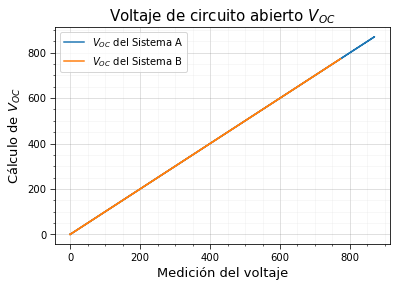

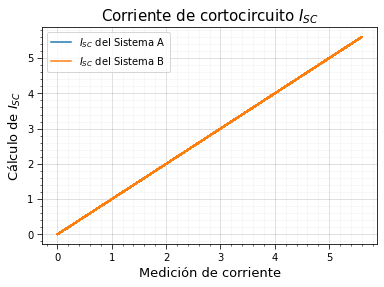

In [59]:
# En Excel->"Radiación" se realizó el reemplazo de los datos ≤ 1.5 W/m2 por cero

# Correcciones de datos
df_corr = pd.read_excel(io=file_name, sheet_name=sheet2)
df_corr.loc[df_corr['DC Current SysA (A)'] >= 9.5, 'DC Current SysA (A)'] = 9.5
df_corr.loc[df_corr['DC Current SysB (A)'] >= 5.6, 'DC Current SysB (A)'] = 5.6

# Conseguir los datos Tmod
df_temp = pd.read_excel(io=file_name, sheet_name=sheet6)
T_mod=df_temp["Tmod (degC)"]

# Conseguir los datos V_DC
df_volt = pd.read_excel(io=file_name, sheet_name=sheet1)
    # Datos voltaje sistema B
volt_sistA=df_volt["DC Voltage SysB (V)"]
    # Datos voltaje sistema A
volt_sistB=df_volt["DC Voltage SysA (V)"]

    # Encontrar V_oc -> Ec. 1
V_oc_A= volt_sistA-(0.0026)*(T_mod-25)
V_oc_B= volt_sistB-(0.0026)*(T_mod-25)

# Consguir los datos DC Current
    # Datos DC current sistema B
corr_sistB=df_corr['DC Current SysB (A)']
    # Datos DC current sistema A
corr_sistA=df_corr['DC Current SysB (A)']

    # Encontrar I_sc -> Ec. 2
I_sc_A= corr_sistA +(0.0002)*(T_mod-25)
I_sc_B= corr_sistB +(0.0002)*(T_mod-25)

# Gráfica 1: Relación entre la medición del voltaje y el cálculo de V_oc

V_x1=volt_sistA
V_x2=volt_sistB
V_y1=V_oc_A
V_y2=V_oc_B

plt.figure()
plt.plot(V_x1, V_y1, label = "$V_{OC}$ del Sistema A")
plt.plot(V_x2, V_y2, label = "$V_{OC}$ del Sistema B")
formato_grafica(titulo='Voltaje de circuito abierto $V_{OC}$', 
                ejex='Medición del voltaje', 
                ejey='Cálculo de $V_{OC}$')
plt.show()
              
# Gráfica 2: Relación entre la medición de corriente y el cálculo de I_sc

I_x1=corr_sistA
I_x2=corr_sistB
I_y1=I_sc_A
I_y2=I_sc_B

plt.figure()
plt.plot(I_x1, I_y1, label = "$I_{SC}$ del Sistema A")
plt.plot(I_x2, I_y2, label = "$I_{SC}$ del Sistema B")
formato_grafica(titulo='Corriente de cortocircuito $I_{SC}$', 
                ejex='Medición de corriente', 
                ejey='Cálculo de $I_{SC}$')
plt.show()

## 2.2. Medición de la potencia DC y el cálculo de $P_{DC}$

Determinar la potencia eléctrica en corriente directa a partir de la multiplicación del voltaje y la corriente para conseguir un aproximado de la potencia producida por la irradancia solar a partir de la siguiente ecuación:
$$
P_{DC}=(V_{OC}*I_{SC})*PS*PP \hspace{1cm} (3)
$$

Tomando valores por separado para cada sistema de:
- **PS**: Cantidad de paneles en serie 
- **PP**: Cantidad de paneles en paralelo

A partir de las soluciones se realiza una gráfica que relaciona la medición de la potencia DC y el cálculo de $P_{DC}$ correspondiente a cada sistema.


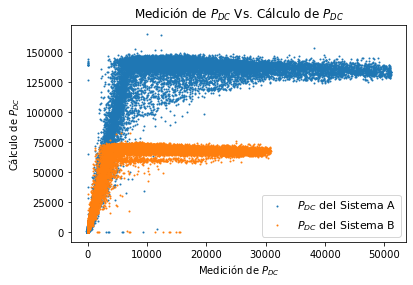

In [60]:
# Sistema A
    # Cálculo de P_DC (incluye porcentaje de pérdidas 26,9%) -> Ec. 3
prodA=V_oc_A*I_sc_A
P_DC_A=(prodA*16*8)*0.269
   
# Sistema B
    # Cálculo de P_DC (incluye porcentaje de pérdidas 26,9%) -> Ec. 3
prodB=V_oc_B*I_sc_B
P_DC_B=(prodB*18*4)*0.269


# Gráfica de ambos sistemas
df_P_DC= pd.read_excel(io=file_name, sheet_name=sheet4)
P_sistA= df_P_DC["DC Power SysA (W)"]
P_sistB= df_P_DC["DC Power SysB (W)"]


    # Sistema A
P_A_x= P_sistA
P_A_y= P_DC_A
    #Sistema B
P_B_x= P_sistB
P_B_y= P_DC_B


plt.figure()
plt.scatter(P_A_x, P_A_y, label = "$P_{DC}$ del Sistema A",s=1)
plt.scatter(P_B_x, P_B_y, label = "$P_{DC}$ del Sistema B",s=1)
plt.title('Medición de $P_{DC}$ Vs. Cálculo de $P_{DC}$') 
plt.xlabel('Medición de $P_{DC}$') 
plt.ylabel('Cálculo de $P_{DC}$')
plt.legend(loc='best', fontsize=11) 
plt.show()


## 2.3. Medición de potencia DC y el cálculo de cálculo de $P_{DC}$ a partir del modelo de potencia de NREL PVWatts

Estimar la potencia DC a partir del modelo de potencia de NREL PVWatts:
$$
P_{DC}=(G_{PO A}/1000)P_{DC_{O}}[1+\gamma(T_{mod}-T_{mod,STC})] \hspace{1cm} (4)
$$

Con los datos del marco teórico del proyecto, sin depender del sistema:
$$
P_{DC}=(G_{PO A}/1000)P_{DC_{O}}[1+(-0.0036)(T_{mod}-25)] 
$$

Tomando las variables:
* $G_{PO A}$: Irradiancia de la celda de referencia
* $P_{DC_{O}}$: Potencia indicada por la capacidad instalada

A partir de las soluciones se realiza una gráfica que correlaciona la medición de la potencia DC y el cálculo de $P_{DC}$ a partir del modelo de potencia NREL PVWatts para cada sistema. 


c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


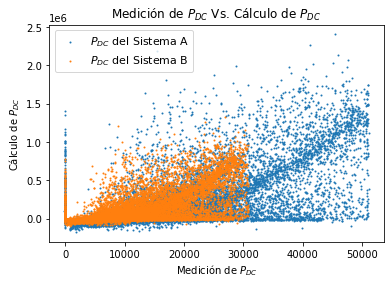

In [61]:
# Conseguir los valores de irradiancia
df_rad=pd.read_excel(io=file_name, sheet_name=sheet0)
G_PO=df_rad["Meteocontrol Irrad (W/m2)"] 
# Sistema A
    # Cálculo P_DC
P_NREL_A=(G_PO/1000)*(50881.8)*(1-0.0036)*(T_mod-25)

# Sistema B
    # Cálculo P_DC
P_NREL_B=(G_PO/1000)*(28199.2)*(1-0.0036)*(T_mod-25)

# Gráfica de ambos sistemas
plt.figure()
plt.scatter(P_A_x, P_NREL_A, label = "$P_{DC}$ del Sistema A",s=1)
plt.scatter(P_B_x, P_NREL_B, label = "$P_{DC}$ del Sistema B",s=1)
plt.title('Medición de $P_{DC}$ Vs. Cálculo de $P_{DC}$') 
plt.xlabel('Medición de $P_{DC}$') 
plt.ylabel('Cálculo de $P_{DC}$')
plt.legend(loc='best', fontsize=11) 
plt.show()



## 2.4. Medición de la potencia AC y el cálculo de $P_{AC}$ a partir del modelo de potencia de NREL PVWatts

Conversión Potencia DC -> AC con el modelo matemático de NREL PVWatts.
$$
\eta=η_{nom}/0.9637(-0.0162 * \zeta-0.0059/\zeta+0.9858) \hspace{1cm} (5)
$$
$$
P_{AC}=MIN(η * P_{DC},P_{AC_{0}}) \hspace{1cm} (6)
$$
$$
\zeta=P_{DC}/P_{DC_{0}} \hspace{1cm} (7)
$$

Tomando:
* $\eta$: Eficiencia en la inversión de energía (es decir, de DC a AC)
* $\eta _{nom}$: Eficiencia nominal del inversor
* $P_{DC_{0}}$: Potencia DC indicada por la capacidad instalada.

Tomando los datos del marco teórico del proyecto se realiza una gráfica donde se correlaciona la medición de la potencia AC y el cálculo de $P_{AC}$ a partir del modelo de potencia de NREL PVWatts para cada sistema. 

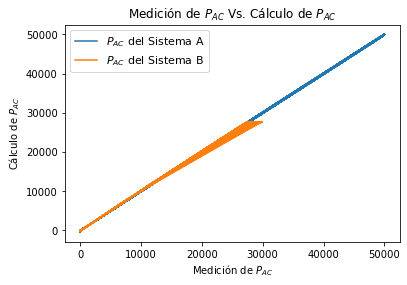

In [62]:
# Sistema A
    # 1. Calcular ζ -> Ec. 7
ζ_A=P_sistA/50881.8
    # 2. Calcular η -> Ec. 5
η_A=(0.98184/0.9637)*(-0.0162*ζ_A+((-0.0059/ζ_A)+0.9858))
    # Encontrar el valor de P_AC
#min_A= np.min(η_A*P_sistA)
P_AC_A= np.minimum(η_A*P_sistA,50000)

# Sistema B
    # 1. Calcular ζ -> Ec. 7
ζ_B=P_sistB/28199.2
    # 2. Calcular η -> Ec. 5
η_B=(0.97761/0.9637)*(-0.0162*ζ_B+(0.9858-(0.0059/ζ_B)))
    # Encontrar el valor de P_AC
#min_B= np.min(η_B*P_sistB)
P_AC_B= np.minimum(η_B* P_sistB,27600)


# Gráfrica
df_P_AC= pd.read_excel(io=file_name, sheet_name=sheet5)
AC_sistA= df_P_AC["AC Power SysA (W)"]
AC_sistB= df_P_AC["AC Power SysB (W)"]


plt.figure()
plt.plot(AC_sistA, P_AC_A, label = "$P_{AC}$ del Sistema A")
plt.plot(AC_sistB, P_AC_B, label = "$P_{AC}$ del Sistema B")
plt.title('Medición de $P_{AC}$ Vs. Cálculo de $P_{AC}$') 
plt.xlabel('Medición de $P_{AC}$') 
plt.ylabel('Cálculo de $P_{AC}$')
plt.legend(loc='best', fontsize=11) 
plt.show()



## 2.5. Correlación entre la medición de $P_{AC_{T}}$ y el cálculo de $P_{AC}$ a partir de la suma de las potencias AC calculadas con el modelo NREL PVWatts

La potencia AC total es la suma de aquella generada por cada inversor, como se ve en la siguiente ecuación:
$$
P_{AC_{Parque}}=P_{AC_{Sistema A}}+P_{AC_{Sistema B}} \hspace{1cm} (8)
$$


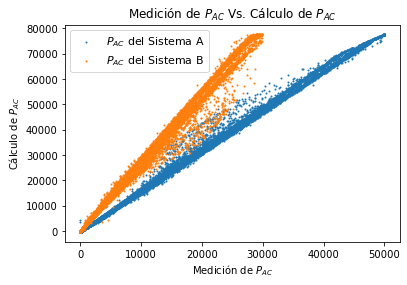

In [65]:
# Suma de P_AC_Total -> Ec. 8
P_AC_Total= P_AC_A + P_AC_B

plt.figure()
plt.scatter(AC_sistA, P_AC_Total, label = "$P_{AC}$ del Sistema A",s=1)
plt.scatter(AC_sistB, P_AC_Total, label = "$P_{AC}$ del Sistema B",s=1)
plt.title('Medición de $P_{AC}$ Vs. Cálculo de $P_{AC}$') 
plt.xlabel('Medición de $P_{AC}$') 
plt.ylabel('Cálculo de $P_{AC}$')
plt.legend(loc='best', fontsize=11) 
plt.show()


# Sección 3

## 3.1. Bibliografía

[1] Mancera y Salazar-Peña. (2021). Detección de Fallas en Sistemas Solares
Fotovoltaicos por Medio de Modelado y Algoritmos Computacionales.
Universidad de los Andes. Departamento de Ingeniería Mecánica. Bogotá, D.C.,
Colombia.